In [449]:
import pandas as pd
import jqdatasdk as jq
import datetime
from joblib import Parallel, delayed
import multiprocessing
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
import numpy.linalg as lg
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] #SimHei是黑体的意思

In [ ]:
'''
全样本 - BL模型实现

N 可选资产数量
T 样本时间长度（观测数）
K 观点数 - 随意做的，没有分析师观点，基于换手率和pb（rolling2次）计算四个观点，对应收益率随意设定
'''

In [2]:
## 全数据 - 面板数据堆叠形式
ind_trade_value = pd.read_csv('C:/Users/jxjsj/Desktop/JupyterHome/Data/industry.csv')

In [101]:
## 收益率部分
return_data = ind_trade_value.pivot_table(index='date',columns='code',values='close').fillna(method='ffill').dropna()
return_data.index = pd.DatetimeIndex(return_data.index.tolist())
return_mat = return_data.pct_change().dropna()

In [431]:
## 资产顺序
code_list = return_mat.columns.tolist()

In [102]:
## 以收益率序列日期作为所用样本期间
start_day = return_mat.index.tolist()[0].strftime('%Y-%m-%d')
end_day = return_mat.index.tolist()[-1].strftime('%Y-%m-%d')
ind_trade_value_sub = ind_trade_value[(ind_trade_value['date']>=start_day) & (ind_trade_value['date']<=end_day)]

In [103]:
## 无风险收益率
rf = 0.02

In [130]:
## 协方差矩阵 NxN
return_cov_mat = return_mat.cov()

In [105]:
## 市值权重序列矩阵 TxN
mcap_mat = ind_trade_value_sub.pivot_table(index='date',columns='code',values='circulating_market_cap').fillna(method='ffill')
tolmcap_series = mcap_mat.sum(axis=1)
for col in mcap_mat.columns:
    mcap_mat[col] = mcap_mat[col]/tolmcap_series

In [432]:
## 均衡市场权重Wm Nx1
Weight_M = mcap_mat.mean().T.to_frame('Weight_M')
Weight_M = Weight_M/Weight_M.sum()
Weight_M = np.array(Weight_M)

In [112]:
## N
N = len(Weight_M)

In [108]:
## 全行业，即市场，收益率序列（各行业每日市值加权） Tx1
MKT_return_series = (return_mat*mcap_mat).sum(axis=1).to_frame('MKT')

In [140]:
## 风险厌恶系数sigma
sigma = float((np.mean(MKT_return_series)*252-rf)/(np.var(MKT_return_series)*252))

In [53]:
## 比例关系常数 n/m 投资者观察到的资产数量/市场中观察到的资产数量 - 0.01~0.05
te = 0.02

In [115]:
## 隐含均衡收益率 - MK效用函数最大化无约束求解，权重给定为市场均衡权重，求解最优收益率
PI = sigma*np.dot(return_cov_mat,Weight_M)*252

In [204]:
## 投资者观点矩阵 KxN
## 观点1 - 历史长期平均换手率，越低越看好
turnover_matL = ind_trade_value_sub.pivot_table(index='date',columns='code',values='turnover_ratio').fillna(method='ffill')/100
turnover_matL = 1/turnover_matL.rolling(252).mean().iloc[-1,]
turnover_matL = (turnover_matL/turnover_matL.sum()).to_frame('turnoverL')
## 观点2 - 历史短期平均换手率，越低越看好
turnover_matS = ind_trade_value_sub.pivot_table(index='date',columns='code',values='turnover_ratio').fillna(method='ffill')/100
turnover_matS = 1/turnover_matS.rolling(126).mean().iloc[-1,]
turnover_matS = (turnover_matS/turnover_matS.sum()).to_frame('turnoverS')
## 观点3 - 历史长期平均市净率，越低越看好
pb_matL = ind_trade_value_sub.pivot_table(index='date',columns='code',values='pb').fillna(method='ffill')/100
pb_matL = 1/pb_matL.rolling(252).mean().iloc[-1,]
pb_matL = (pb_matL/pb_matL.sum()).to_frame('pbL')
## 观点4 - 历史短期平均市净率，越低越看好
pb_matS = ind_trade_value_sub.pivot_table(index='date',columns='code',values='pb').fillna(method='ffill')/100
pb_matS = 1/pb_matS.rolling(126).mean().iloc[-1,]
pb_matS = (pb_matS/pb_matS.sum()).to_frame('pbS')

P = pd.concat([turnover_matL,turnover_matS,pb_matL,pb_matS],axis=1).T

In [205]:
## 观点对应收益率预测矩阵 Kx1
Q = np.array([[0.1],[0.08],[0.07],[0.05]])

In [166]:
## K
K = len(Q)

In [399]:
## 观点置信度对角矩阵估计 - 分析矩阵结构，其中许多矩阵其实为标量；置信度插值系数C对每个观点为Nx1
omegaj_mat = []

for j in range(K):
    Pj = np.array(P)[j]
    Pj_T = Pj.reshape(len(Pj),-1)
    Qj = Q[j]
    mat0 = te*np.dot(return_cov_mat,Pj_T)
    mat1 = 1/np.dot(Pj,te*np.dot(return_cov_mat,Pj.T))
    mat2 = Qj-np.dot(Pj,PI)
    uj = PI+mat0*mat1*mat2
    mat3 = lg.inv(sigma*return_cov_mat*252)
    wj = np.dot(mat3,uj)
    wj_ = Weight_M+(wj-Weight_M)*0.95
    
    def square_sum_wj(omegaj):
        mat0 = lg.inv(sigma*return_cov_mat*252)
        mat1 = np.dot(Pj_T,Pj.reshape(1,len(Pj)))*(1/omegaj)
        mat2 = np.dot(Pj_T,Qj)*(1/omegaj)
        mat2 = mat2.reshape(len(mat2),-1)

        mat3 = lg.inv(mat0 + mat1)
        mat4 = np.dot(mat0,PI) + mat2

        wjj = np.dot(mat0,np.dot(mat3,mat4))

        return np.dot((wj_ - wjj).T,(wj_ - wjj))
    
    
    bnds = [(0.00000001,np.inf)]
    omigaj = sco.minimize(square_sum_wj, 0.1, bounds = bnds,method = 'SLSQP')['x']
    
    omegaj_mat.append(omigaj[0])
OMEGA = np.diag(omigaj_mat)

In [376]:
## 后验期望收益率
mat0 = lg.inv(te*return_cov_mat*252)
mat1 = np.dot(np.dot(P.T,lg.inv(OMEGA)),P)
mat2 = np.dot(np.dot(P.T,lg.inv(OMEGA)),Q)
E_R = np.dot(lg.inv(mat0+mat1),(np.dot(mat0,PI)+mat2))

In [415]:
## BL权重求解
def MVOunity(w):
    return -(np.dot(w.T,E_R)-0.5*sigma*np.dot(np.dot(w.T,return_cov_mat*252),w))
cons = ({'type':'eq','fun':lambda x: sum(x)-1})
bonds = [(0.,np.inf) for i in range(N)]
initial_w = N*[1./N,]
BLweight = list(sco.minimize(MVOunity, initial_w, bounds = bonds, constraints = cons, method = 'SLSQP')['x'])

In [ ]:
## 权重分配展示
for i in BLweight

In [404]:
## BL权重求解
def MVOunity(w):
    return -(np.dot(w.T,E_R)-0.5*sigma*np.dot(np.dot(w.T,return_cov_mat*252),w))
cons = ({'type':'eq','fun':lambda x: sum(x)-1})

initial_w = N*[1./N,]
BLweight = sco.minimize(MVOunity, initial_w, constraints = cons, method = 'SLSQP')['x']

In [439]:
code_name = ind_trade_value_sub[['name','code']].drop_duplicates(subset=None, keep='first', inplace=False)
BLweiht_name = pd.DataFrame({'BLweight':BLweight,'code':code_list})
BLweiht_name_code = BLweiht_name.merge(code_name,on=['code'])

In [ ]:
'''
结果展示，依然很不均衡
'''

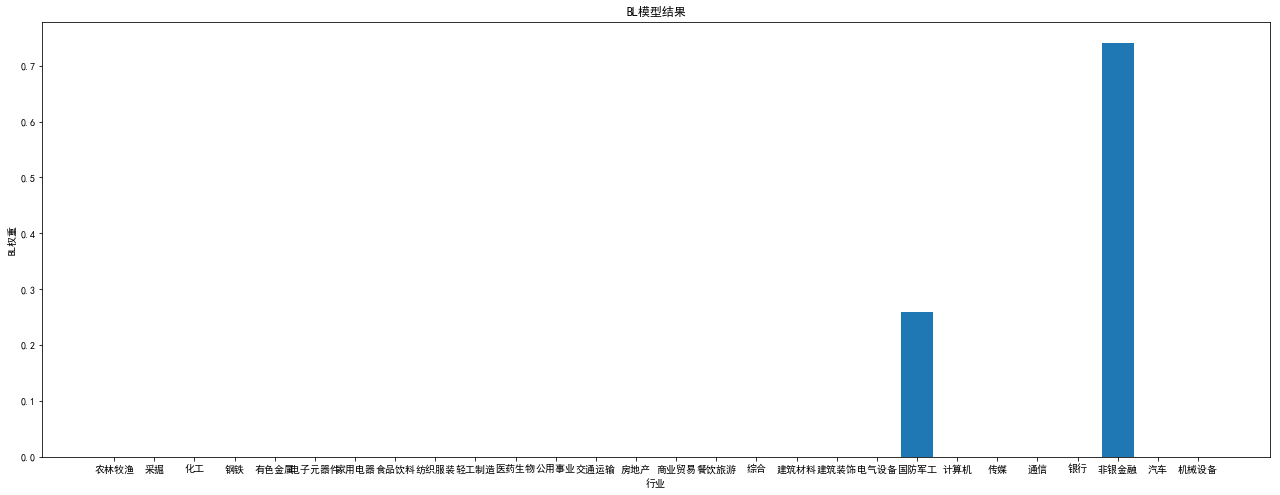

In [457]:
from matplotlib.font_manager import FontProperties
plt.figure(figsize=(22, 8))
plt.bar(x=BLweiht_name_code['name'],height=BLweiht_name_code['BLweight'])
plt.ylabel('BL权重')
plt.xlabel('行业')
plt.title('BL模型结果')
plt.show()